# Project 1: Advanced Lane Finding

In this notebook, we present the necessary steps to build a pipeline to identify lane lines in a video file. The notebook consists of 6 sub-sections, as per the instructions:

1. Compute the camera calibration matrix and distrotion coefficients given a set of chessboard images.

2. Apply a distortion correction to raw images.

3. Use color transforms, gradients, etc., to create a thresholded binary image.

4. Apply a perspective transform to rectify binary image ("birds-eye view").

5. Detect lane pixels and fit to find the lane boundary.

6. Determine the curvature of the lane and vehicle position with respect to center.

7. Warp the detected lane boundaries back onto the original image.

8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## 0. Import the necessary modules

Here, we import the necessary packages and modules to run the code below. We use the aliases as in the lectures.

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from aux_functions import *
import importlib
%matplotlib inline

## 1. Compute camera calibration


We start by identifying the corners on the maximum number of calibrating images possible, so that we obtain a 2d-3d mapping, leading to a robust calibration.

In [2]:
# Set the number of corners (nx,ny) to (9,6)
nx=9
ny=6

# The list containing the names of the files corresponding to the camera images
list_fnames=os.listdir('camera_cal/')

# The arrays to hold the parameters
initialpoints =[] # 3D points
targetpoints=[] # 2D points
c=0 #To count the number of succesful corner identifications
for file in list_fnames:
    file=os.path.join('camera_cal/',file)
    img=cv2.imread(file)
   
    initialp=np.zeros((nx*ny,3),np.float32)

    #Set the first two columns to x and y
    initialp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)


    # Convert to grayscale and find the corners
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret==True :
        targetpoints.append(corners)
        initialpoints.append(initialp)
        c+=1

print("The calibration of the canera will be performed using {} 3d-2d mappings.".format(c))


The calibration of the canera will be performed using 17 3d-2d mappings.


We have now obtained the mappings. In the next line, we use the function cv2.calibrateCamera to calibrate the cameram making use of the 17 mappings calculated above.

In [3]:
retval, cameraMatrix, distCoeffs, rvecs, tvecs=cv2.calibrateCamera(initialpoints, targetpoints,gray.shape[::-1],None,None)
print("Calibration is ready to test.")

Calibration is ready to test.


Let us then test the calibration on the first image.

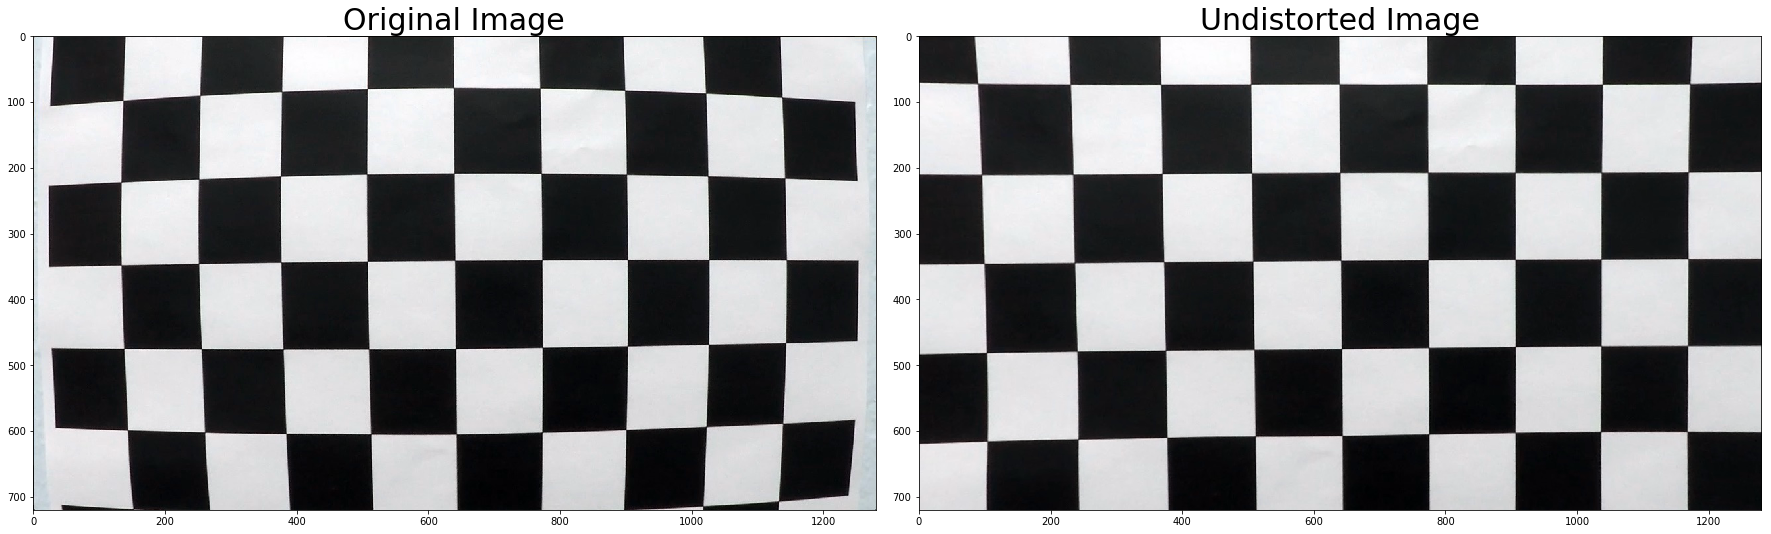

In [4]:
# Pick the first image for distortion correction
img=cv2.imread('camera_cal/calibration1.jpg')
undist=cv2.undistort(img,cameraMatrix,distCoeffs,None,cameraMatrix)

# Set the plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

The distortion correction looks satisfying. As such, we are now ready to apply distortion correction to all the images in the folder 'camera_cal'.

## 2. Apply distortion correction to all raw images.

We apply the correction, and save the results in the 'images_output' folder.

In [5]:
path='output_images'
for i in range(len(list_fnames)):
    file=os.path.join('camera_cal/',list_fnames[i])
    img=cv2.imread(file)
    undist=cv2.undistort(img,cameraMatrix,distCoeffs,None,cameraMatrix)
    file_sname='calibration'+str(i+1) +'_undistorted.jpg'
    plt.imsave(os.path.join(path,file_sname),undist)



We now move to creating a treshold binary image. For clarity, we move the function to the file aux_functions.py

## 3. Create threshold binary image using color space and gradient

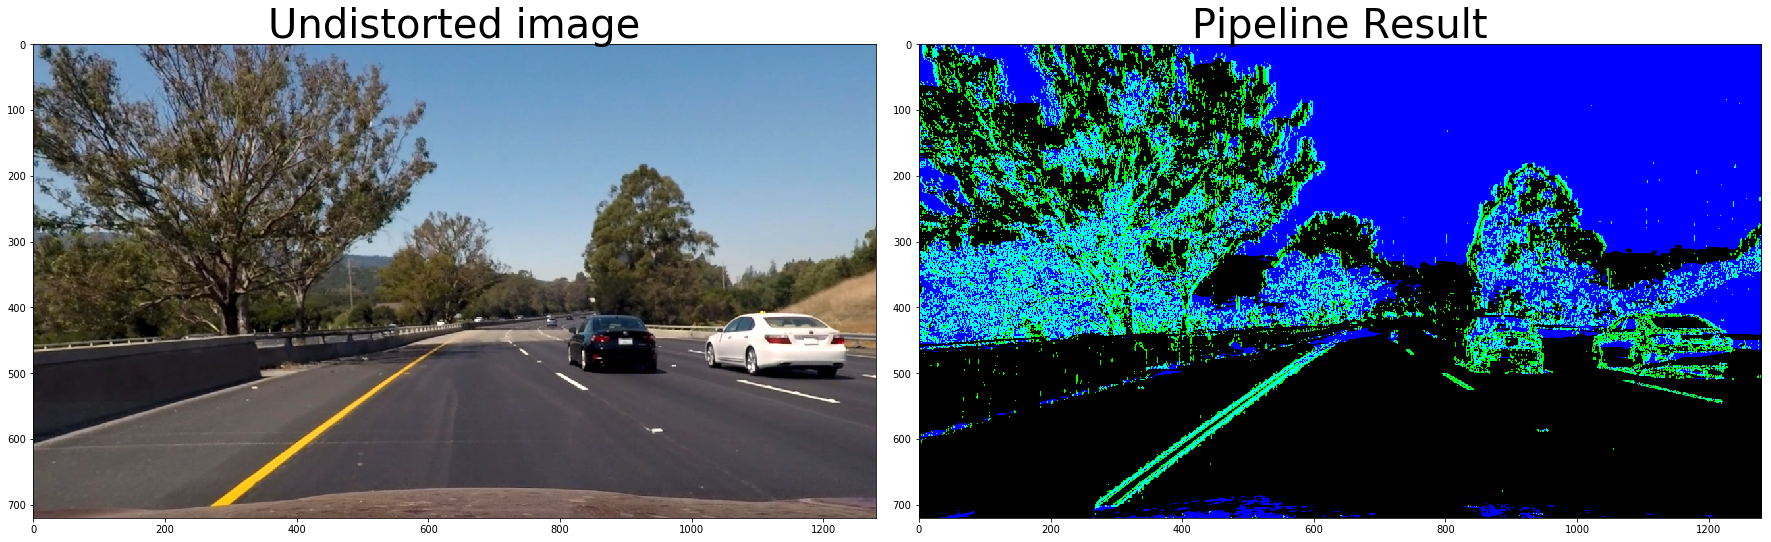

In [6]:



# We use the first image of test images
path='test_images/'
list_fnames=os.listdir(path)
image_test=mpimg.imread(os.path.join(path,list_fnames[0]))

# Undistort the image
image_test_und=cv2.undistort(image_test,cameraMatrix,distCoeffs,None,cameraMatrix)
result = pipeline_grad_color_thresh(image_test_und,s_thresh=(50, 180), sx_thresh=(10, 190))


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_test_und)
ax1.set_title('Undistorted image', fontsize=40)

#Note that we use the last chanel
ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

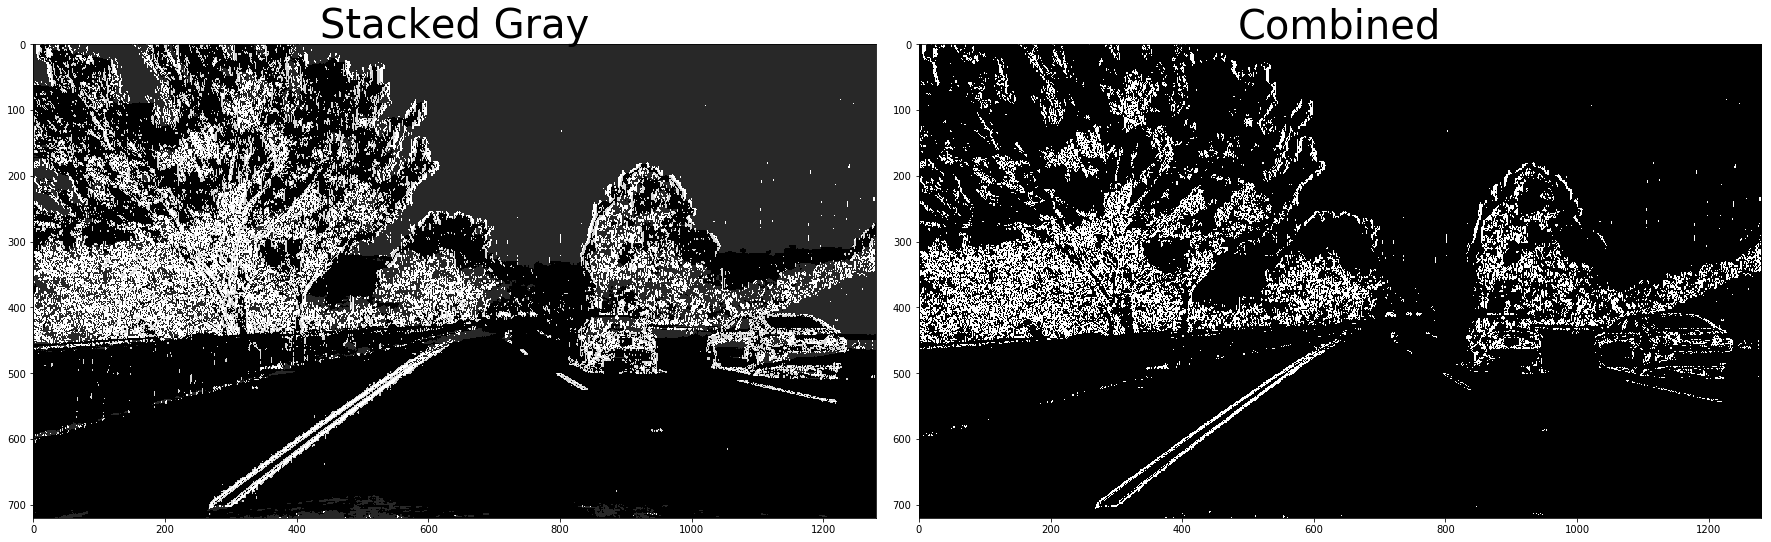

In [7]:
# We now plot both stacked and combined gradient and color space

#Define the chanels
sxbinary=result[:,:,1]
scbinary=result[:,:,2]
combined_binary = np.zeros_like(sxbinary)
combined_binary[(scbinary == 255) & (sxbinary == 255)] = 1
gray=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
# Plot stacked gray and combined
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray,cmap='gray')
ax1.set_title('Stacked Gray', fontsize=40)
ax2.imshow(combined_binary,cmap='gray')
ax2.set_title('Combined', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

We can now apply a perspective transofrm to the bottom half of the image. But first lets try to find an image to calibrate it.

# 4. Perspective transform


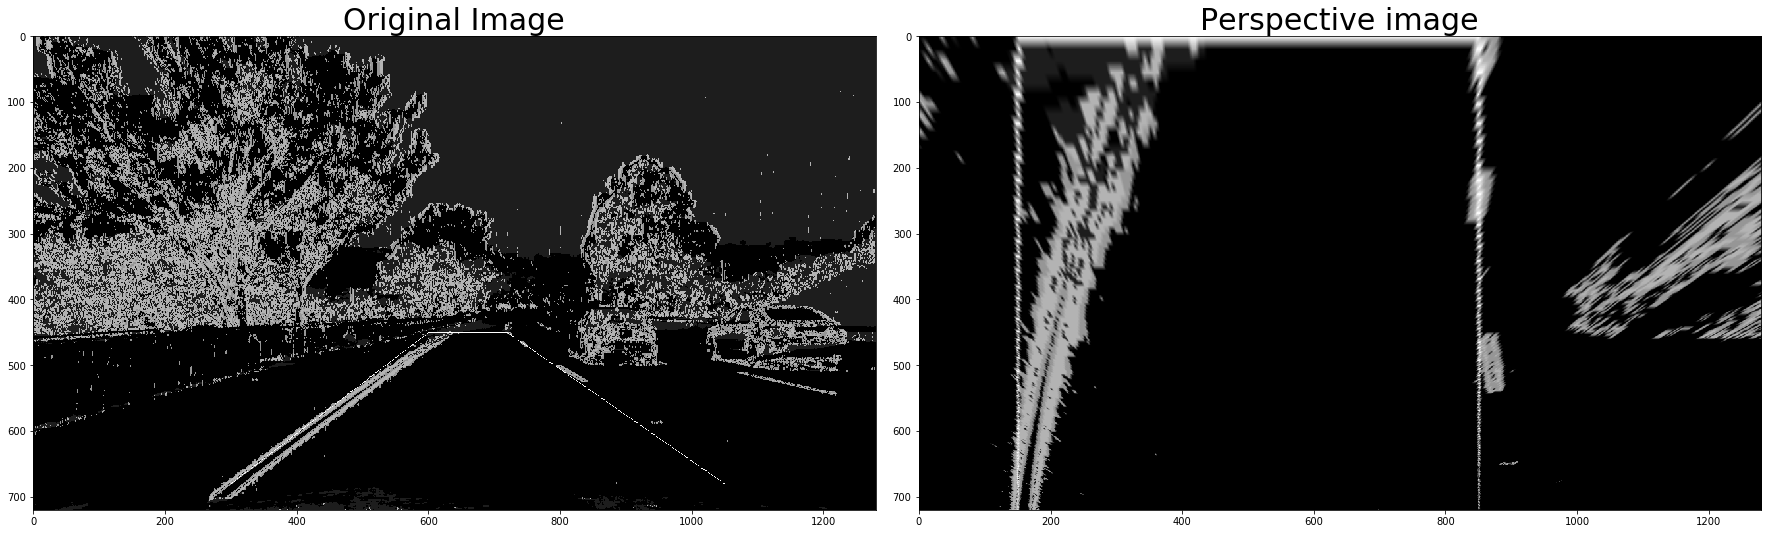

In [8]:
# polygon 1
#src=np.float32([[290,680],[590,478],[704,478],[900,675]])
gray=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

x_l=700
y_l=720
src=np.float32([[300,680],[600,450],[720,450],[1050,680]])
dst= np.float32([[150,y_l],[150,0],[150+x_l,0],[150+x_l,y_l]])


#dst= np.float32([[250,680],[250,205],[900,210],[1000,900]])

# Let us plot the polygon
line_1=cv2.line(gray,tuple(src[0]),tuple(src[1]),(255,0,0),1)
line_2=cv2.line(gray,tuple(src[1]),tuple(src[2]),(255,0,0),1)
line_3=cv2.line(gray,tuple(src[2]),tuple(src[3]),(255,0,0),1)
line_4=cv2.line(gray,tuple(src[3]),tuple(src[0]),(255,0,0),1)
# Get the transform matrix
M=cv2.getPerspectiveTransform(src,dst)
# Warp the image
warped=cv2.warpPerspective(gray,M,gray.shape[::-1],flags=cv2.INTER_LINEAR)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray,cmap='gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Perspective image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



We can use the right-hand image to fit the polynomials to the lanes.

## 5. Detect lane pixels and fit the polynomials
We use the function fit_polynomial. This function yields the fitted image, and the coefficients of both right and left fit.


[-1.08893631e-04 -5.55368502e-02  2.47965960e+02] [ 1.91577769e-04 -6.89775765e-02  8.56104512e+02]


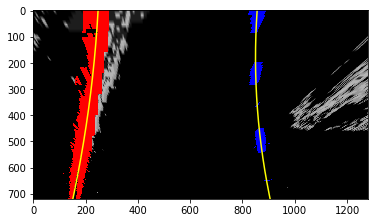

In [9]:
#Get the image again, and warp it
from aux_functions import fit_polynomial
gray=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
warped=cv2.warpPerspective(gray,M,gray.shape[::-1],flags=cv2.INTER_LINEAR)

left_fit,right_fit,out_img=fit_polynomial(warped)
plt.imshow(out_img)
print(left_fit, right_fit)

## 6. Determine the radio of curvature and the position of the vehicle position with respect to the center

We use an auxilliary function.

In [13]:
def measure_curvature_distance_real(binary_warped,left_fit, right_fit,x_l,y_l):
    '''
    Calculates the curvature  of the road and the vehicle distance from the center in meters.
    '''
    # Define conversions in x and y from pixels space to meters using the measures defined in the notebook.
    ym_per_pix = 30/y_l # meters per pixel in y dimension
    xm_per_pix = 3.7/x_l # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)*ym_per_pix
    
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**(3/2)/(2*np.abs(left_fit[0]))
    
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**(3/2)/(2*np.abs(right_fit[0])) 
    
    # Determine the center of the image
    center_x=binary_warped.shape[1]//2
    center_y=binary_warped.shape[0]//2
    # The height of the points is the same, the center of the lane is at the level of the center of the image, and is given as the midpoint between the left and right polynomial fit given at y=binary_warped.shape[0]//2
    left_midx = left_fit[0]*center_y**2 + left_fit[1]*center_y + left_fit[2]
    right_midx = right_fit[0]*center_y**2 + right_fit[1]*center_y + right_fit[2]
    mid_lane_x=(left_midx+right_midx)//2
    cv2.line(binary_warped,(np.int(center_x),np.int(center_y)),(np.int(mid_lane_x),np.int(center_y)),(255,255,0),2)
    distance=np.abs(mid_lane_x - center_x) * xm_per_pix
    return left_curverad, right_curverad, distance, binary_warped

In [14]:
left_curverad, right_curverad,distance, out_img = measure_curvature_distance_real(out_img,left_fit,right_fit,x_l,y_l)

The radius of curvature of the left lane is 4618.190142337755 m.
The radius of curvature of the right lane is 2622.859850452286 m.
The distance between the vehicle and the middle of the lane is 0.5602857142857143 m


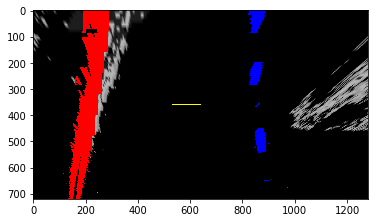

In [19]:
print("The radius of curvature of the left lane is {} m.".format(left_curverad))
print("The radius of curvature of the right lane is {} m.".format(right_curverad))
print("The distance between the vehicle and the middle of the lane is {} m".format(distance))
plt.imshow(out_img)


We follow up with the calculation of the vehicle position.

## 7. Warp back the image

We now warp back the image.

In [17]:
unwarped_back=cv2.warpPerspective(out_img,M,gray.shape[::-1],flags=cv2.WARP_INVERSE_MAP)

(720, 1280, 3)


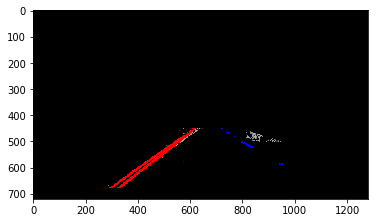

In [18]:
plt.imshow(unwarped_back[:,:,])
print(result.shape)

One can see that the detected pixels coincide with the lanes.We can overlay the image with the original chanel S to check the fit.

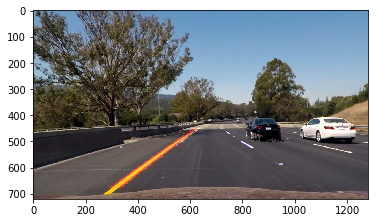

In [20]:

image_lanes=image_test_und.copy()
# Produce a weighted image
resulting=cv2.addWeighted(unwarped_back,0.5,image_lanes,1.0,0)

plt.imshow(resulting)


The fit is reasonable. 

## 8. Output visual display of the lanes, their curvature, and the vehicle position.

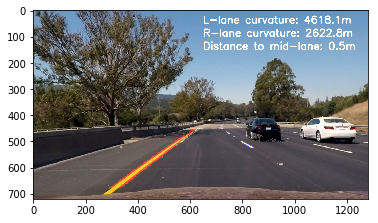

In [22]:
resulting_a=resulting.copy()
cv2.putText(resulting_a, "L-lane curvature: "+ str(left_curverad)[:6] + "m", (650, 50), cv2.FONT_ITALIC, 1.3,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
cv2.putText(resulting_a, "R-lane curvature: "+ str(right_curverad)[:6] + "m", (650, 100), cv2.FONT_ITALIC, 1.3,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)
cv2.putText(resulting_a, "Distance to mid-lane: "+ str(distance)[:3] + "m", (650, 150), cv2.FONT_ITALIC, 1.3,  (255, 255, 255), thickness=3, lineType=cv2.LINE_AA)



plt.imshow(resulting_a)